# 🥈 Bước 3: Silver Layer - Transformation & Làm sạch dữ liệu

## Credit Card Fraud Detection - IEEE-CIS Dataset

**Mục tiêu:**
- Làm sạch dữ liệu từ Bronze Layer
- Xử lý missing values, data types
- Join Transaction với Identity data
- Demo Schema Evolution của Iceberg (thêm cột mới)
- Tạo các features cơ bản cho phân tích fraud

## 1. Khởi tạo Spark Session

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *

# Khởi tạo Spark Session với Iceberg
spark = SparkSession.builder \
    .appName("Silver Layer - Fraud Detection") \
    .config("spark.sql.extensions", "org.apache.iceberg.spark.extensions.IcebergSparkSessionExtensions") \
    .config("spark.sql.catalog.demo", "org.apache.iceberg.spark.SparkCatalog") \
    .config("spark.sql.catalog.demo.type", "rest") \
    .config("spark.sql.catalog.demo.uri", "http://iceberg-rest:8181") \
    .config("spark.sql.catalog.demo.io-impl", "org.apache.iceberg.aws.s3.S3FileIO") \
    .config("spark.sql.catalog.demo.warehouse", "s3://warehouse/") \
    .config("spark.sql.catalog.demo.s3.endpoint", "http://minio:9000") \
    .config("spark.sql.catalog.demo.s3.path-style-access", "true") \
    .config("spark.sql.catalog.demo.s3.access-key-id", "admin") \
    .config("spark.sql.catalog.demo.s3.secret-access-key", "password123") \
    .config("spark.sql.defaultCatalog", "demo") \
    .config("spark.hadoop.fs.s3a.endpoint", "http://minio:9000") \
    .config("spark.hadoop.fs.s3a.access.key", "admin") \
    .config("spark.hadoop.fs.s3a.secret.key", "password123") \
    .config("spark.hadoop.fs.s3a.path.style.access", "true") \
    .config("spark.hadoop.fs.s3a.impl", "org.apache.hadoop.fs.s3a.S3AFileSystem") \
    .getOrCreate()

print("✅ Spark Session đã khởi tạo thành công!")

✅ Spark Session đã khởi tạo thành công!


26/02/02 07:17:05 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [2]:
# Tạo namespace Silver
spark.sql("CREATE NAMESPACE IF NOT EXISTS demo.silver")
print("📁 Namespaces trong Catalog:")
spark.sql("SHOW NAMESPACES IN demo").show()

📁 Namespaces trong Catalog:
+-------------+
|    namespace|
+-------------+
|       bronze|
|  bronze_gold|
|bronze_silver|
|      default|
|       silver|
+-------------+



## 2. Đọc dữ liệu từ Bronze Layer

In [3]:
# Đọc dữ liệu từ Bronze tables
df_transactions = spark.table("demo.bronze.transactions")
df_identity = spark.table("demo.bronze.identity")

print(f"📊 Bronze Transactions: {df_transactions.count():,} rows")
print(f"📊 Bronze Identity: {df_identity.count():,} rows")

📊 Bronze Transactions: 590,540 rows
📊 Bronze Identity: 144,233 rows


## 3. Phân tích Missing Values

In [4]:
# Phân tích missing values cho các cột quan trọng
important_cols = ['TransactionID', 'isFraud', 'TransactionAmt', 'ProductCD', 
                  'card1', 'card2', 'card3', 'card4', 'card5', 'card6',
                  'addr1', 'addr2', 'P_emaildomain', 'R_emaildomain']

print("📊 Phân tích Missing Values (các cột quan trọng):")
print("-" * 50)

for col_name in important_cols:
    if col_name in df_transactions.columns:
        null_count = df_transactions.filter(col(col_name).isNull()).count()
        total = df_transactions.count()
        null_pct = (null_count / total) * 100
        print(f"{col_name:20s}: {null_count:>10,} nulls ({null_pct:.2f}%)")

📊 Phân tích Missing Values (các cột quan trọng):
--------------------------------------------------
TransactionID       :          0 nulls (0.00%)
isFraud             :          0 nulls (0.00%)
TransactionAmt      :          0 nulls (0.00%)
ProductCD           :          0 nulls (0.00%)
card1               :          0 nulls (0.00%)


card2               :      8,933 nulls (1.51%)
card3               :      1,565 nulls (0.27%)
card4               :      1,577 nulls (0.27%)
card5               :      4,259 nulls (0.72%)
card6               :      1,571 nulls (0.27%)
addr1               :     65,706 nulls (11.13%)
addr2               :     65,706 nulls (11.13%)
P_emaildomain       :     94,456 nulls (15.99%)
R_emaildomain       :    453,249 nulls (76.75%)


/tmp/ipykernel_1092/3263355648.py:48: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


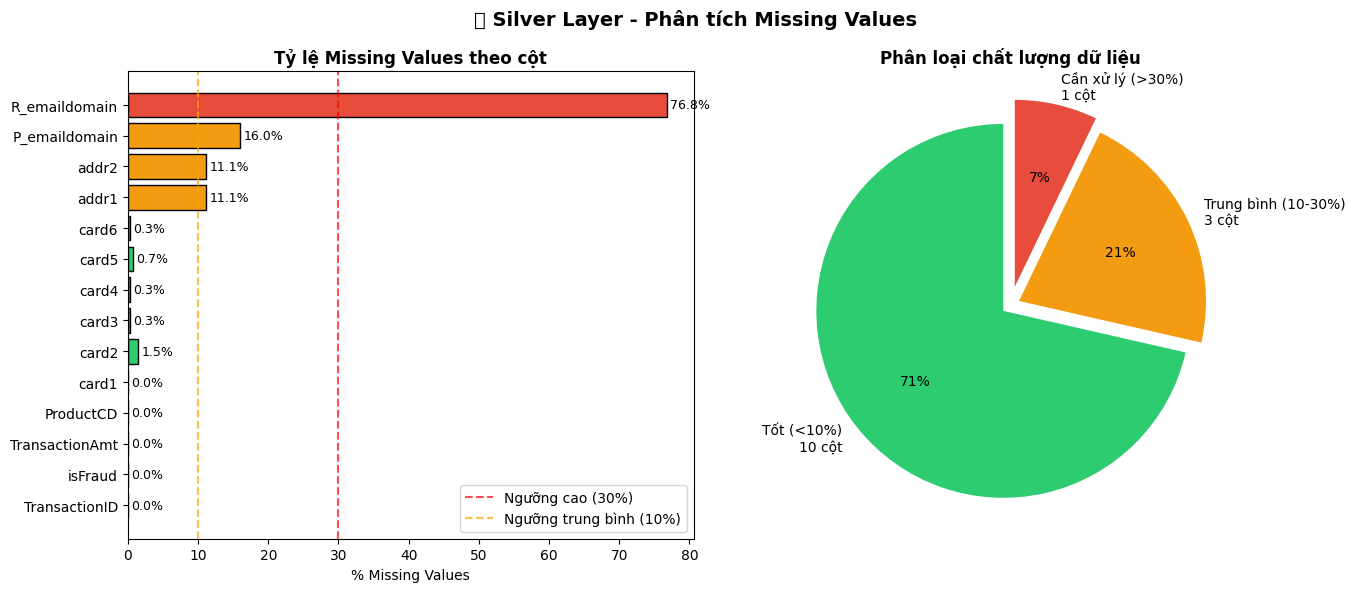

📊 Tổng kết Missing Values:
   - Cột có chất lượng tốt (<10% null): 10
   - Cột cần chú ý (10-30% null): 3
   - Cột cần xử lý (>30% null): 1


In [6]:
# 📊 VISUALIZATION: Missing Values Analysis
import matplotlib.pyplot as plt
import numpy as np
import builtins  # Import builtins để sử dụng sum() gốc của Python

# Collect missing values data
missing_data = []
for col_name in important_cols:
    if col_name in df_transactions.columns:
        null_count = df_transactions.filter(col(col_name).isNull()).count()
        total = df_transactions.count()
        null_pct = (null_count / total) * 100
        missing_data.append({'column': col_name, 'null_count': null_count, 'null_pct': null_pct})

# Create visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle('📊 Silver Layer - Phân tích Missing Values', fontsize=14, fontweight='bold')

# 1. Bar chart: Missing values count
columns = [d['column'] for d in missing_data]
null_pcts = [d['null_pct'] for d in missing_data]
colors = ['#e74c3c' if p > 30 else '#f39c12' if p > 10 else '#2ecc71' for p in null_pcts]

bars = axes[0].barh(columns, null_pcts, color=colors, edgecolor='black')
axes[0].set_xlabel('% Missing Values')
axes[0].set_title('Tỷ lệ Missing Values theo cột', fontsize=12, fontweight='bold')
axes[0].axvline(x=30, color='red', linestyle='--', alpha=0.7, label='Ngưỡng cao (30%)')
axes[0].axvline(x=10, color='orange', linestyle='--', alpha=0.7, label='Ngưỡng trung bình (10%)')
axes[0].legend(loc='lower right')

for bar, pct in zip(bars, null_pcts):
    axes[0].text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2, 
                 f'{pct:.1f}%', va='center', fontsize=9)

# 2. Pie chart: Data Quality Overview
# Sử dụng len() với list comprehension thay vì sum() (bị PySpark override)
high_missing = len([p for p in null_pcts if p > 30])
medium_missing = len([p for p in null_pcts if 10 < p <= 30])
low_missing = len([p for p in null_pcts if p <= 10])

sizes = [low_missing, medium_missing, high_missing]
labels = [f'Tốt (<10%)\n{low_missing} cột', f'Trung bình (10-30%)\n{medium_missing} cột', f'Cần xử lý (>30%)\n{high_missing} cột']
colors_pie = ['#2ecc71', '#f39c12', '#e74c3c']

axes[1].pie(sizes, labels=labels, colors=colors_pie, autopct='%1.0f%%', startangle=90, explode=(0.05, 0.05, 0.1))
axes[1].set_title('Phân loại chất lượng dữ liệu', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

print("📊 Tổng kết Missing Values:")
print(f"   - Cột có chất lượng tốt (<10% null): {low_missing}")
print(f"   - Cột cần chú ý (10-30% null): {medium_missing}")
print(f"   - Cột cần xử lý (>30% null): {high_missing}")

## 4. Làm sạch và Tạo Silver Transactions

In [7]:
# Chọn các cột quan trọng cho phân tích Fraud Detection
# Và làm sạch dữ liệu

df_transactions_clean = df_transactions.select(
    # ID và Target
    col("TransactionID"),
    col("isFraud").cast("integer"),
    
    # Transaction info
    col("TransactionAmt").cast("double"),
    col("TransactionDT").cast("integer"),
    col("ProductCD"),
    
    # Card info
    col("card1").cast("integer"),
    col("card2").cast("double"),
    col("card3").cast("double"),
    col("card4"),  # visa, mastercard, etc
    col("card5").cast("double"),
    col("card6"),  # credit, debit
    
    # Address
    col("addr1").cast("double"),
    col("addr2").cast("double"),
    
    # Email domains
    col("P_emaildomain"),
    col("R_emaildomain"),
    
    # Device info columns (C1-C14)
    col("C1").cast("double"),
    col("C2").cast("double"),
    col("C3").cast("double"),
    col("C4").cast("double"),
    col("C5").cast("double"),
    col("C6").cast("double"),
    col("C7").cast("double"),
    col("C8").cast("double"),
    col("C9").cast("double"),
    col("C10").cast("double"),
    col("C11").cast("double"),
    col("C12").cast("double"),
    col("C13").cast("double"),
    col("C14").cast("double"),
    
    # Metadata
    col("_ingestion_time"),
    col("_source_file")
)

print(f"✅ Đã chọn {len(df_transactions_clean.columns)} cột quan trọng")
df_transactions_clean.printSchema()

✅ Đã chọn 31 cột quan trọng
root
 |-- TransactionID: integer (nullable = true)
 |-- isFraud: integer (nullable = true)
 |-- TransactionAmt: double (nullable = true)
 |-- TransactionDT: integer (nullable = true)
 |-- ProductCD: string (nullable = true)
 |-- card1: integer (nullable = true)
 |-- card2: double (nullable = true)
 |-- card3: double (nullable = true)
 |-- card4: string (nullable = true)
 |-- card5: double (nullable = true)
 |-- card6: string (nullable = true)
 |-- addr1: double (nullable = true)
 |-- addr2: double (nullable = true)
 |-- P_emaildomain: string (nullable = true)
 |-- R_emaildomain: string (nullable = true)
 |-- C1: double (nullable = true)
 |-- C2: double (nullable = true)
 |-- C3: double (nullable = true)
 |-- C4: double (nullable = true)
 |-- C5: double (nullable = true)
 |-- C6: double (nullable = true)
 |-- C7: double (nullable = true)
 |-- C8: double (nullable = true)
 |-- C9: double (nullable = true)
 |-- C10: double (nullable = true)
 |-- C11: double (nu

In [8]:
# Thêm các features mới cho Silver Layer
df_silver_transactions = df_transactions_clean \
    .withColumn("transaction_hour", (col("TransactionDT") % 86400 / 3600).cast("integer")) \
    .withColumn("transaction_day", (col("TransactionDT") / 86400).cast("integer")) \
    .withColumn("amt_log", log1p(col("TransactionAmt"))) \
    .withColumn("is_high_amount", when(col("TransactionAmt") > 500, 1).otherwise(0)) \
    .withColumn("card_type", 
                when(col("card4").isNull(), "unknown")
                .otherwise(col("card4"))) \
    .withColumn("card_category",
                when(col("card6").isNull(), "unknown")
                .otherwise(col("card6"))) \
    .withColumn("_transformation_time", current_timestamp())

print(f"✅ Đã thêm features mới cho Silver Transactions")
print(f"📊 Tổng số cột: {len(df_silver_transactions.columns)}")

✅ Đã thêm features mới cho Silver Transactions
📊 Tổng số cột: 38


/tmp/ipykernel_1092/68749027.py:47: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


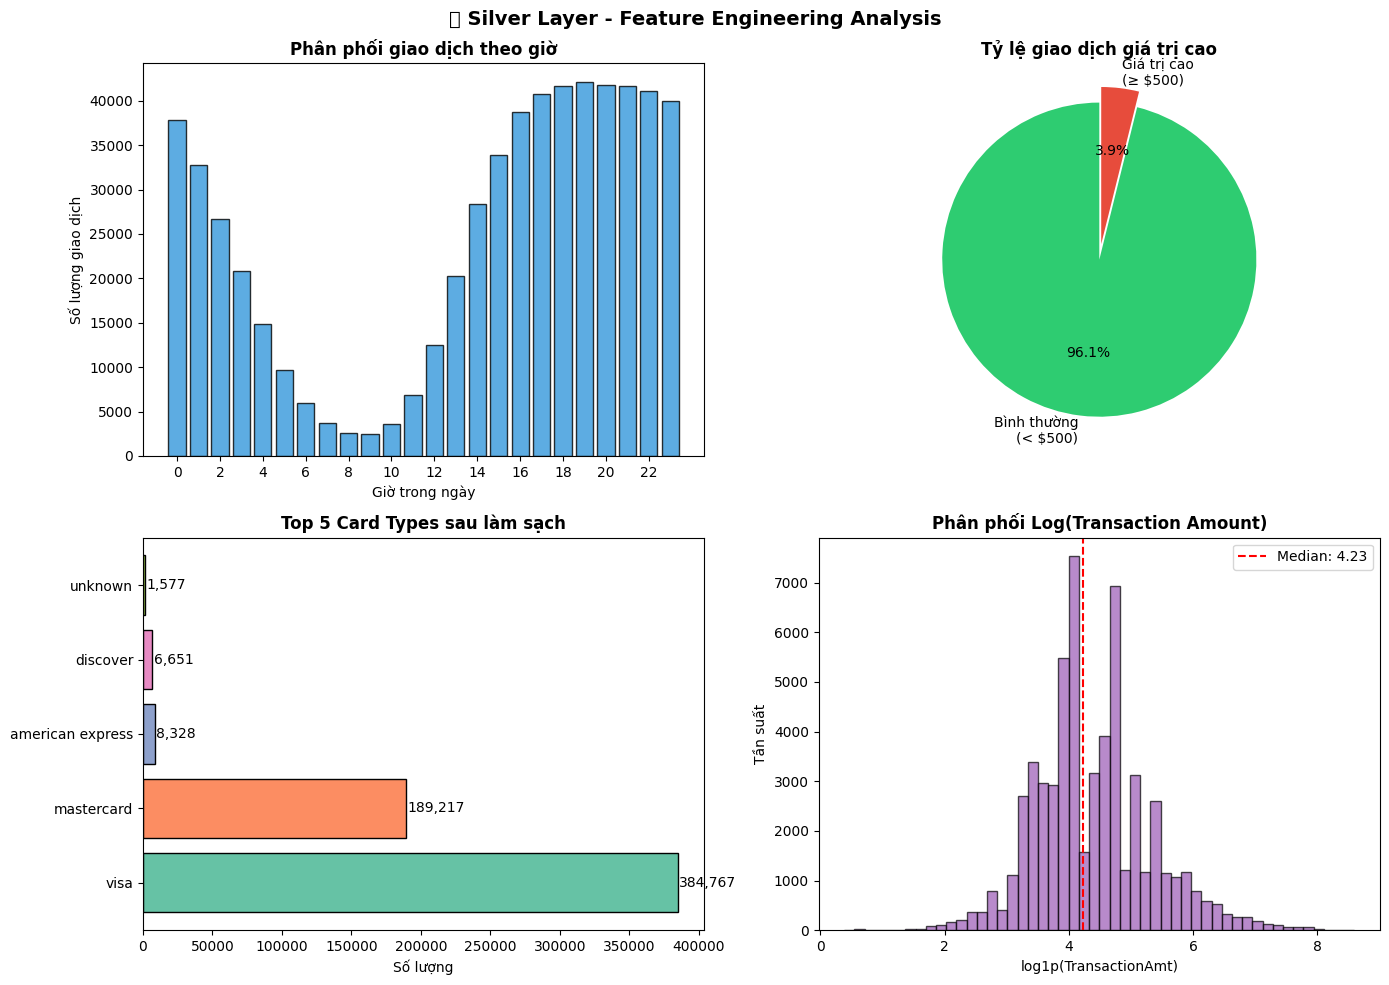

📊 Feature Engineering hoàn tất!
   - Tổng số features mới: transaction_hour, transaction_day, amt_log, is_high_amount, card_type, card_category


In [9]:
# 📊 VISUALIZATION: Feature Engineering Results
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('📊 Silver Layer - Feature Engineering Analysis', fontsize=14, fontweight='bold')

# 1. Transaction Hour Distribution
hour_data = df_silver_transactions.groupBy("transaction_hour").count().orderBy("transaction_hour").collect()
hours = [row['transaction_hour'] for row in hour_data]
hour_counts = [row['count'] for row in hour_data]

axes[0, 0].bar(hours, hour_counts, color='#3498db', edgecolor='black', alpha=0.8)
axes[0, 0].set_title('Phân phối giao dịch theo giờ', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Giờ trong ngày')
axes[0, 0].set_ylabel('Số lượng giao dịch')
axes[0, 0].set_xticks(range(0, 24, 2))

# 2. High Amount Transactions
high_amt_data = df_silver_transactions.groupBy("is_high_amount").count().collect()
high_amt = {row['is_high_amount']: row['count'] for row in high_amt_data}
labels = ['Bình thường\n(< $500)', 'Giá trị cao\n(≥ $500)']
sizes = [high_amt.get(0, 0), high_amt.get(1, 0)]
colors = ['#2ecc71', '#e74c3c']

axes[0, 1].pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90, explode=(0, 0.1))
axes[0, 1].set_title('Tỷ lệ giao dịch giá trị cao', fontsize=12, fontweight='bold')

# 3. Card Type Distribution
card_type_data = df_silver_transactions.groupBy("card_type").count().orderBy("count", ascending=False).collect()
card_types = [str(row['card_type']) for row in card_type_data[:5]]
card_counts = [row['count'] for row in card_type_data[:5]]

bars = axes[1, 0].barh(card_types, card_counts, color=plt.cm.Set2(range(5)), edgecolor='black')
axes[1, 0].set_title('Top 5 Card Types sau làm sạch', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Số lượng')
for bar, cnt in zip(bars, card_counts):
    axes[1, 0].text(bar.get_width() + 1000, bar.get_y() + bar.get_height()/2, f'{cnt:,}', va='center')

# 4. Log Amount Distribution
amt_log_sample = df_silver_transactions.select("amt_log").sample(0.1).toPandas()
axes[1, 1].hist(amt_log_sample['amt_log'], bins=50, color='#9b59b6', edgecolor='black', alpha=0.7)
axes[1, 1].set_title('Phân phối Log(Transaction Amount)', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('log1p(TransactionAmt)')
axes[1, 1].set_ylabel('Tần suất')
axes[1, 1].axvline(x=amt_log_sample['amt_log'].median(), color='red', linestyle='--', 
                    label=f'Median: {amt_log_sample["amt_log"].median():.2f}')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

print("📊 Feature Engineering hoàn tất!")
print(f"   - Tổng số features mới: transaction_hour, transaction_day, amt_log, is_high_amount, card_type, card_category")

In [10]:
# Ghi Silver Transactions vào Iceberg
df_silver_transactions.writeTo("demo.silver.transactions") \
    .tableProperty("format-version", "2") \
    .createOrReplace()

print("✅ Đã tạo bảng demo.silver.transactions!")

26/02/02 07:19:32 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


✅ Đã tạo bảng demo.silver.transactions!


## 5. Làm sạch và Join với Identity Data

In [11]:
# Làm sạch Identity data
df_identity_clean = df_identity.select(
    col("TransactionID"),
    col("DeviceType"),
    col("DeviceInfo"),
    col("id_01").cast("double").alias("id_score_01"),
    col("id_02").cast("double").alias("id_score_02"),
    col("id_03").cast("double").alias("id_score_03"),
    col("id_04").cast("double").alias("id_score_04"),
    col("id_05").cast("double").alias("id_score_05"),
    col("id_06").cast("double").alias("id_score_06"),
    col("id_11").cast("double").alias("id_score_11"),
    col("id_12").alias("id_12"),
    col("id_13").alias("id_13"),
    col("id_14").alias("id_14"),
    col("id_15").alias("id_15"),
    col("id_16").alias("id_16"),
    col("id_17").cast("double").alias("id_score_17"),
    col("id_18").cast("double").alias("id_score_18"),
    col("id_19").cast("double").alias("id_score_19"),
    col("id_20").cast("double").alias("id_score_20"),
    col("id_28").alias("id_28"),
    col("id_29").alias("id_29"),
    col("id_30").alias("browser_version"),
    col("id_31").alias("browser"),
    col("id_32").cast("double").alias("screen_size"),
    col("id_33").alias("screen_resolution"),
    col("id_34").alias("match_status"),
    col("id_35").alias("id_35"),
    col("id_36").alias("id_36"),
    col("id_37").alias("id_37"),
    col("id_38").alias("id_38")
)

# Thêm device category
df_silver_identity = df_identity_clean \
    .withColumn("device_category",
                when(col("DeviceType").isNull(), "unknown")
                .otherwise(col("DeviceType"))) \
    .withColumn("_transformation_time", current_timestamp())

print(f"✅ Đã làm sạch Identity data: {df_silver_identity.count():,} rows")

✅ Đã làm sạch Identity data: 144,233 rows


In [12]:
# Ghi Silver Identity vào Iceberg
df_silver_identity.writeTo("demo.silver.identity") \
    .tableProperty("format-version", "2") \
    .createOrReplace()

print("✅ Đã tạo bảng demo.silver.identity!")

✅ Đã tạo bảng demo.silver.identity!


In [13]:
# Tạo bảng Join: Transactions + Identity (cho các giao dịch có thông tin identity)
df_silver_full = spark.table("demo.silver.transactions").alias("t") \
    .join(
        spark.table("demo.silver.identity").alias("i"),
        col("t.TransactionID") == col("i.TransactionID"),
        "left"
    ) \
    .select(
        col("t.*"),
        col("i.DeviceType"),
        col("i.DeviceInfo"),
        col("i.device_category"),
        col("i.browser"),
        col("i.browser_version"),
        col("i.screen_size"),
        col("i.id_score_01"),
        col("i.id_score_02"),
        col("i.id_score_05"),
        col("i.id_score_06")
    )

# Ghi vào bảng silver.transactions_full
df_silver_full.writeTo("demo.silver.transactions_full") \
    .tableProperty("format-version", "2") \
    .createOrReplace()

print(f"✅ Đã tạo bảng demo.silver.transactions_full với {df_silver_full.count():,} rows")

✅ Đã tạo bảng demo.silver.transactions_full với 590,540 rows


## 6. Demo Schema Evolution của Iceberg

Theo yêu cầu đề bài: Giả lập thay đổi cấu trúc dữ liệu nguồn (thêm cột mới), Iceberg phải tự động xử lý mà không cần viết lại toàn bộ dữ liệu.

In [14]:
# Schema hiện tại của bảng
print("📋 Schema hiện tại của demo.silver.transactions:")
spark.sql("DESCRIBE demo.silver.transactions").show(truncate=False)

📋 Schema hiện tại của demo.silver.transactions:
+--------------+---------+-------+
|col_name      |data_type|comment|
+--------------+---------+-------+
|TransactionID |int      |NULL   |
|isFraud       |int      |NULL   |
|TransactionAmt|double   |NULL   |
|TransactionDT |int      |NULL   |
|ProductCD     |string   |NULL   |
|card1         |int      |NULL   |
|card2         |double   |NULL   |
|card3         |double   |NULL   |
|card4         |string   |NULL   |
|card5         |double   |NULL   |
|card6         |string   |NULL   |
|addr1         |double   |NULL   |
|addr2         |double   |NULL   |
|P_emaildomain |string   |NULL   |
|R_emaildomain |string   |NULL   |
|C1            |double   |NULL   |
|C2            |double   |NULL   |
|C3            |double   |NULL   |
|C4            |double   |NULL   |
|C5            |double   |NULL   |
+--------------+---------+-------+
only showing top 20 rows



In [15]:
# DEMO Schema Evolution: Thêm cột mới "risk_score" mà KHÔNG cần viết lại dữ liệu
# Iceberg hỗ trợ schema evolution một cách trong suốt

print("🔄 Thêm cột 'risk_score' vào bảng silver.transactions...")
spark.sql("""
    ALTER TABLE demo.silver.transactions 
    ADD COLUMN risk_score DOUBLE COMMENT 'Risk score calculated for fraud detection'
""")

print("🔄 Thêm cột 'payment_method' vào bảng silver.transactions...")
spark.sql("""
    ALTER TABLE demo.silver.transactions 
    ADD COLUMN payment_method STRING COMMENT 'Payment method inferred from card type'
""")

print("✅ Schema Evolution thành công! Không cần viết lại dữ liệu.")
print("\n📋 Schema mới:")
spark.sql("DESCRIBE demo.silver.transactions").show(truncate=False)

🔄 Thêm cột 'risk_score' vào bảng silver.transactions...
🔄 Thêm cột 'payment_method' vào bảng silver.transactions...
✅ Schema Evolution thành công! Không cần viết lại dữ liệu.

📋 Schema mới:
+--------------+---------+-------+
|col_name      |data_type|comment|
+--------------+---------+-------+
|TransactionID |int      |NULL   |
|isFraud       |int      |NULL   |
|TransactionAmt|double   |NULL   |
|TransactionDT |int      |NULL   |
|ProductCD     |string   |NULL   |
|card1         |int      |NULL   |
|card2         |double   |NULL   |
|card3         |double   |NULL   |
|card4         |string   |NULL   |
|card5         |double   |NULL   |
|card6         |string   |NULL   |
|addr1         |double   |NULL   |
|addr2         |double   |NULL   |
|P_emaildomain |string   |NULL   |
|R_emaildomain |string   |NULL   |
|C1            |double   |NULL   |
|C2            |double   |NULL   |
|C3            |double   |NULL   |
|C4            |double   |NULL   |
|C5            |double   |NULL   |
+----

In [16]:
# Cập nhật giá trị cho các cột mới (MERGE operation)
# Iceberg hỗ trợ UPDATE/MERGE trong format version 2

spark.sql("""
    UPDATE demo.silver.transactions 
    SET risk_score = CASE 
        WHEN isFraud = 1 THEN 0.9 + (RAND() * 0.1)
        WHEN is_high_amount = 1 THEN 0.5 + (RAND() * 0.3)
        ELSE RAND() * 0.3
    END,
    payment_method = CASE
        WHEN card6 = 'credit' THEN 'CREDIT_CARD'
        WHEN card6 = 'debit' THEN 'DEBIT_CARD'
        ELSE 'OTHER'
    END
""")

print("✅ Đã cập nhật giá trị cho các cột mới!")

# Kiểm tra kết quả
spark.sql("""
    SELECT TransactionID, isFraud, TransactionAmt, card6, payment_method, risk_score
    FROM demo.silver.transactions 
    LIMIT 10
""").show(truncate=False)

✅ Đã cập nhật giá trị cho các cột mới!
+-------------+-------+--------------+------+--------------+-------------------+
|TransactionID|isFraud|TransactionAmt|card6 |payment_method|risk_score         |
+-------------+-------+--------------+------+--------------+-------------------+
|3283093      |0      |130.5         |debit |DEBIT_CARD    |0.08702547082707283|
|3283094      |0      |39.152        |credit|CREDIT_CARD   |0.10929837779091658|
|3283095      |0      |107.95        |debit |DEBIT_CARD    |0.2191544253898386 |
|3283096      |0      |77.0          |debit |DEBIT_CARD    |0.04674743251790725|
|3283097      |0      |136.0         |debit |DEBIT_CARD    |0.2693913698129674 |
|3283098      |0      |59.0          |debit |DEBIT_CARD    |0.08046005480142936|
|3283099      |0      |77.0          |debit |DEBIT_CARD    |0.17385226246149812|
|3283100      |0      |57.95         |debit |DEBIT_CARD    |0.07281451724044591|
|3283101      |0      |107.95        |debit |DEBIT_CARD    |0.14363749

## 7. Xác minh Silver Layer

In [17]:
# Danh sách các bảng trong Silver Layer
print("📁 Danh sách bảng trong Silver Layer:")
spark.sql("SHOW TABLES IN demo.silver").show()

# Thống kê
print("\n📊 Thống kê Silver Tables:")
for table in ['transactions', 'identity', 'transactions_full']:
    count = spark.sql(f"SELECT COUNT(*) FROM demo.silver.{table}").collect()[0][0]
    print(f"   - silver.{table}: {count:,} records")

📁 Danh sách bảng trong Silver Layer:
+---------+-----------------+-----------+
|namespace|        tableName|isTemporary|
+---------+-----------------+-----------+
|   silver|         identity|      false|
|   silver|     transactions|      false|
|   silver|transactions_full|      false|
+---------+-----------------+-----------+


📊 Thống kê Silver Tables:
   - silver.transactions: 590,540 records
   - silver.identity: 144,233 records
   - silver.transactions_full: 590,540 records


In [18]:
# Kiểm tra Iceberg History - cho thấy Schema Evolution
print("📜 Iceberg Table History (Silver Transactions):")
print("Cho thấy các thao tác: CREATE, ALTER, UPDATE")
spark.sql("SELECT * FROM demo.silver.transactions.history ORDER BY made_current_at").show(truncate=False)

📜 Iceberg Table History (Silver Transactions):
Cho thấy các thao tác: CREATE, ALTER, UPDATE
+-----------------------+-------------------+-------------------+-------------------+
|made_current_at        |snapshot_id        |parent_id          |is_current_ancestor|
+-----------------------+-------------------+-------------------+-------------------+
|2026-02-02 07:19:41.394|8559454621654451792|NULL               |true               |
|2026-02-02 07:20:12.73 |3518827692251387073|8559454621654451792|true               |
+-----------------------+-------------------+-------------------+-------------------+



/tmp/ipykernel_1092/2120751427.py:64: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


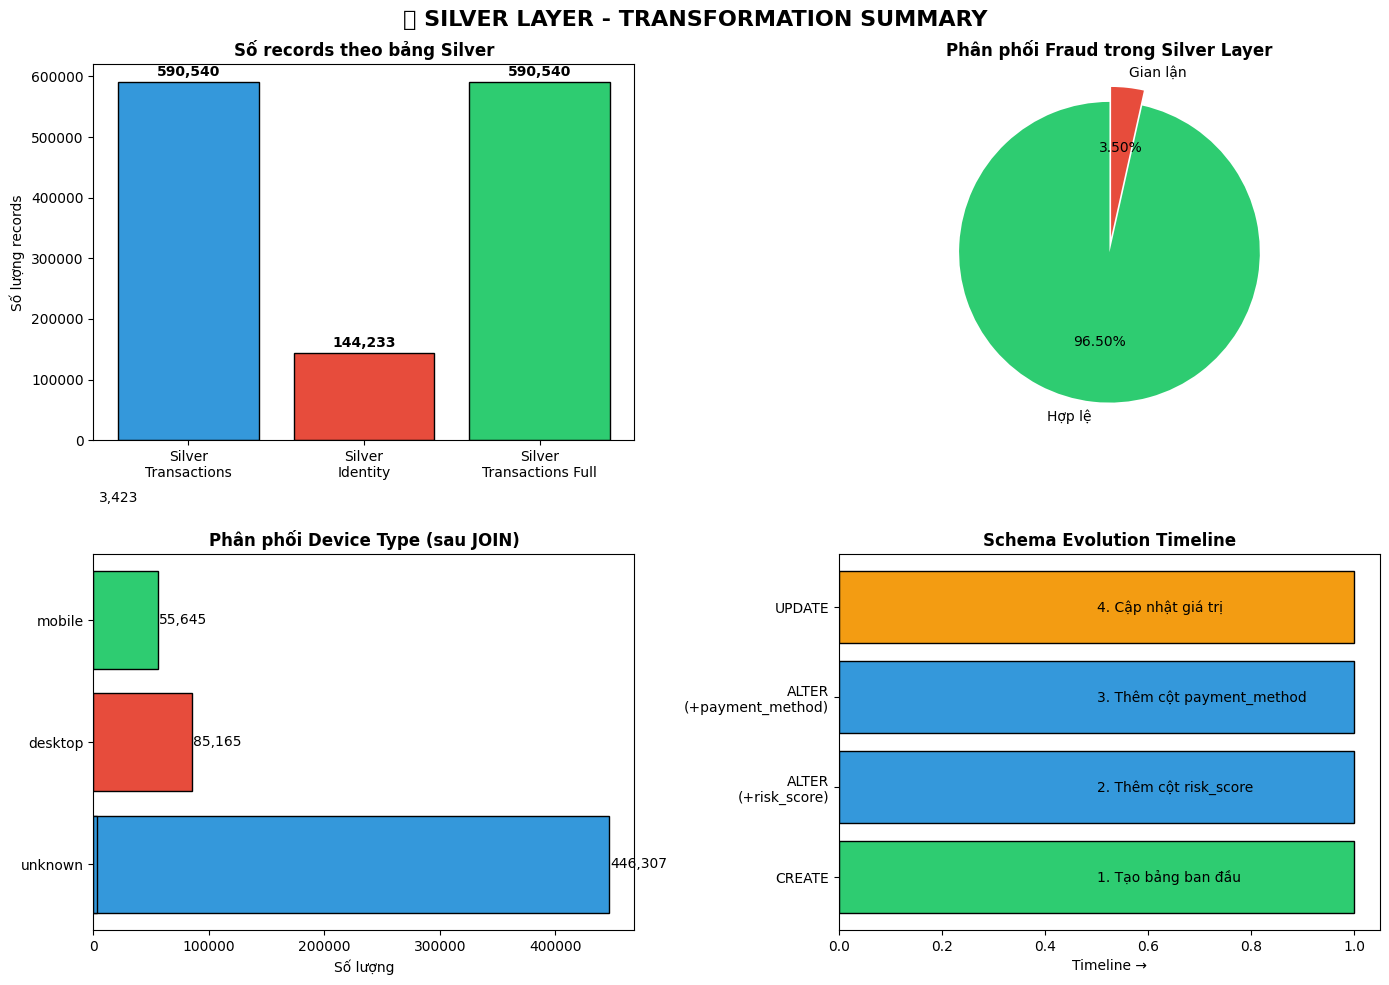

✅ Silver Layer hoàn tất với Schema Evolution!


In [19]:
# 📊 VISUALIZATION: Silver Layer Summary Dashboard
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('📊 SILVER LAYER - TRANSFORMATION SUMMARY', fontsize=16, fontweight='bold')

# 1. Tables Summary
tables = ['Silver\nTransactions', 'Silver\nIdentity', 'Silver\nTransactions Full']
table_counts = [
    spark.sql("SELECT COUNT(*) FROM demo.silver.transactions").collect()[0][0],
    spark.sql("SELECT COUNT(*) FROM demo.silver.identity").collect()[0][0],
    spark.sql("SELECT COUNT(*) FROM demo.silver.transactions_full").collect()[0][0]
]
colors = ['#3498db', '#e74c3c', '#2ecc71']

bars = axes[0, 0].bar(tables, table_counts, color=colors, edgecolor='black')
axes[0, 0].set_title('Số records theo bảng Silver', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Số lượng records')
for bar, cnt in zip(bars, table_counts):
    axes[0, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5000, 
                    f'{cnt:,}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# 2. Fraud Distribution after cleaning
fraud_silver = spark.sql("""
    SELECT isFraud, COUNT(*) as cnt 
    FROM demo.silver.transactions 
    GROUP BY isFraud
""").collect()
fraud_dict = {row['isFraud']: row['cnt'] for row in fraud_silver}
labels = ['Hợp lệ', 'Gian lận']
sizes = [fraud_dict.get(0, 0), fraud_dict.get(1, 0)]
colors_fraud = ['#2ecc71', '#e74c3c']

axes[0, 1].pie(sizes, labels=labels, colors=colors_fraud, autopct='%1.2f%%', 
               startangle=90, explode=(0, 0.1))
axes[0, 1].set_title('Phân phối Fraud trong Silver Layer', fontsize=12, fontweight='bold')

# 3. Device Type Distribution (after join)
device_silver = spark.sql("""
    SELECT COALESCE(device_category, 'unknown') as device, COUNT(*) as cnt 
    FROM demo.silver.transactions_full 
    GROUP BY device_category ORDER BY cnt DESC
""").collect()
devices = [row['device'] for row in device_silver]
device_counts = [row['cnt'] for row in device_silver]

axes[1, 0].barh(devices, device_counts, color=['#3498db', '#e74c3c', '#2ecc71'], edgecolor='black')
axes[1, 0].set_title('Phân phối Device Type (sau JOIN)', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Số lượng')
for i, (dev, cnt) in enumerate(zip(devices, device_counts)):
    axes[1, 0].text(cnt + 1000, i, f'{cnt:,}', va='center')

# 4. Schema Evolution Timeline
operations = ['CREATE', 'ALTER\n(+risk_score)', 'ALTER\n(+payment_method)', 'UPDATE']
y_pos = [0, 1, 2, 3]
colors_op = ['#2ecc71', '#3498db', '#3498db', '#f39c12']

axes[1, 1].barh(operations, [1]*4, color=colors_op, edgecolor='black')
axes[1, 1].set_title('Schema Evolution Timeline', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Timeline →')
axes[1, 1].text(0.5, 0, '1. Tạo bảng ban đầu', ha='left', va='center', fontsize=10)
axes[1, 1].text(0.5, 1, '2. Thêm cột risk_score', ha='left', va='center', fontsize=10)
axes[1, 1].text(0.5, 2, '3. Thêm cột payment_method', ha='left', va='center', fontsize=10)
axes[1, 1].text(0.5, 3, '4. Cập nhật giá trị', ha='left', va='center', fontsize=10)

plt.tight_layout()
plt.show()

print("✅ Silver Layer hoàn tất với Schema Evolution!")

## ✅ Hoàn thành Silver Layer

**Kết quả:**
- ✅ Làm sạch và chuyển đổi dữ liệu từ Bronze → Silver
- ✅ Tạo các features mới: `transaction_hour`, `transaction_day`, `amt_log`, `is_high_amount`
- ✅ Join Transactions với Identity data
- ✅ Demo Schema Evolution: Thêm `risk_score`, `payment_method` mà không viết lại dữ liệu
- ✅ Dữ liệu sẵn sàng cho Gold Layer aggregations

**Tiếp theo:** Chạy notebook `03_gold_layer.ipynb` để tạo các bảng tổng hợp nghiệp vụ.